In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '.jp-Notebook { padding-left: 0% !important; padding-right: 0% !important; width:100% !important; } '
    '</style>'
))

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

matplotlib.style.use("bmh")
font = {'size': 13}
matplotlib.rc('font', **font)

from IPython.display import display

%load_ext autoreload
%autoreload 2
    
import v0_2_0

/tmp/ipykernel_494603/2699245673.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [30]:
COLLECT_TS = "2024-07-31T14:10:52.424946255+00:00"
TARGET_PID = 13646
PATH = "figures/solr"
FIGSIZE = (3.2, 3)
os.makedirs(PATH, exist_ok=True)

# Target Metric

In [3]:
target = pd.read_csv(f"../data/{COLLECT_TS}/application-metrics/request_95.csv")
MIN_TIMESTAMP, MAX_TIMESTAMP = target["epoch_s"].min(), target["epoch_s"].max()

In [4]:
load = pd.read_csv(f"../data/{COLLECT_TS}/application-metrics/test_plan.csv")
load["epoch_s"] = load["epoch_ms"]//1_000

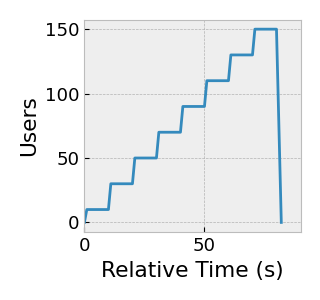

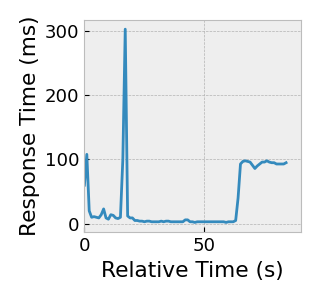

In [31]:
plt.close("all")

plt.figure(figsize=FIGSIZE)
plt.ylabel("Users")
plt.xlabel("Relative Time (s)")
plt.plot(load["epoch_s"] - MIN_TIMESTAMP, load["user_count"])
plt.xlim([0, 90])
plt.tight_layout()
plt.savefig(f"{PATH}/users.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=FIGSIZE)
plt.ylabel("Response Time (ms)")
plt.xlabel("Relative Time (s)")
plt.plot(target["epoch_s"] - MIN_TIMESTAMP, target["delay_ms"])
plt.xlim([0, 90])
plt.tight_layout()
plt.savefig(f"{PATH}/target.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

# Metrics

## Scheduling Statistics

In [8]:
XLIM, YLIM = [20, 85], [0, 1.5]
START_TIMESTAMP = MIN_TIMESTAMP + XLIM[0]
END_TIMESTAMP = MIN_TIMESTAMP + XLIM[1]

plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))

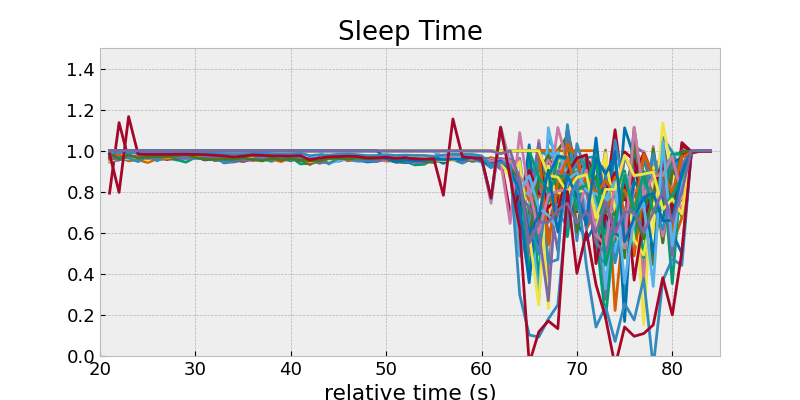

In [9]:
threads = metrics.columns.str.replace(r"thread/\d+/(\d+?)/.*", r"\1", regex=True).unique().drop("epoch_s")
res = {}
for thread in threads:
    res[f"thread/{TARGET_PID}/{thread}/sched/sleep_time_rate"] = 1 - (metrics[f"thread/{TARGET_PID}/{thread}/sched/runtime_rate"] + metrics[f"thread/{TARGET_PID}/{thread}/sched/rq_time_rate"] + metrics[f"thread/{TARGET_PID}/{thread}/sched/block_time_rate"])

sleep_times = pd.DataFrame(res)
sleep_times["epoch_s"] = metrics["epoch_s"]
sleep_times = pd.merge(sleep_times, target, on="epoch_s", how="outer")
sleep_times = sleep_times.loc[(sleep_times["epoch_s"] > START_TIMESTAMP) & (sleep_times["epoch_s"] < END_TIMESTAMP), :]
corr = sleep_times.corr()["delay_ms"]
corr = corr.sort_values(ascending=False)
significant_corr = corr[(corr.abs() > 0.5)]

plt.figure(figsize=(8, 4))
plt.title("Sleep Time")
plt.xlabel("relative time (s)")
threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or "delay_ms" in col or "epoch_ms" in col: 
        continue
    threads = threads.append(pd.Index([col]))
    plt.plot(sleep_times["epoch_s"] - MIN_TIMESTAMP, sleep_times[col])
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.show()

tmp_sleep_threads = threads
tmp_sleep_threads = set(tmp_sleep_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())

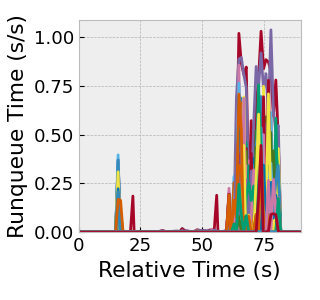

Interesting runqueue threads 72


In [32]:
XLIM, YLIM = [20, 85], [0, 1.5]
START_TIMESTAMP = MIN_TIMESTAMP + XLIM[0]
END_TIMESTAMP = MIN_TIMESTAMP + XLIM[1]

plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))

# Sched Runqueue

col_filter = metrics.columns[metrics.columns.str.contains("rq_time_rate")].append(pd.Index(["epoch_s"]))
rq = metrics.loc[:, col_filter]
rq = pd.merge(rq, target, on="epoch_s", how="outer")
rq = rq.loc[(rq["epoch_s"] > START_TIMESTAMP) & (rq["epoch_s"] < END_TIMESTAMP), :]
corr = rq.corr()["delay_ms"]
corr = corr.sort_values(ascending=False)
significant_corr = corr[corr.abs() > 0.3]

plt.figure(figsize=FIGSIZE)
plt.ylabel("Runqueue Time (s/s)")
plt.xlabel("Relative Time (s)")
rq_threads = pd.Index([])
for col in significant_corr.index: 
    if "epoch_s" in col or "delay_ms" in col or "epoch_ms" in col: 
        continue
    rq_threads = rq_threads.append(pd.Index([col]))
    plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col])
plt.xlim([0, 90])
plt.ylim([0, 1.09])
plt.tight_layout()
plt.savefig(f"{PATH}/runqueue_time.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

rq_threads = set(rq_threads.str.replace(r".*thread/\d+/(\d+)/.*", r"\1", regex=True).unique())

print("Interesting runqueue threads", len(rq_threads))

In [58]:
display(tmp_sleep_threads - rq_threads)
display(rq_threads - tmp_sleep_threads)

{'18348', '18405', '18407', '18414', '18415'}

{'13729', '13731', '18067', '18071', '18076', '18112'}

**Observations:**

There are 15 threads that present a significant change in their sleep pattern at the time there is a fault. Since sleep time has increased, one of the possible causes of this could be futex. As such, this is what we will analyse next. 

## Futex

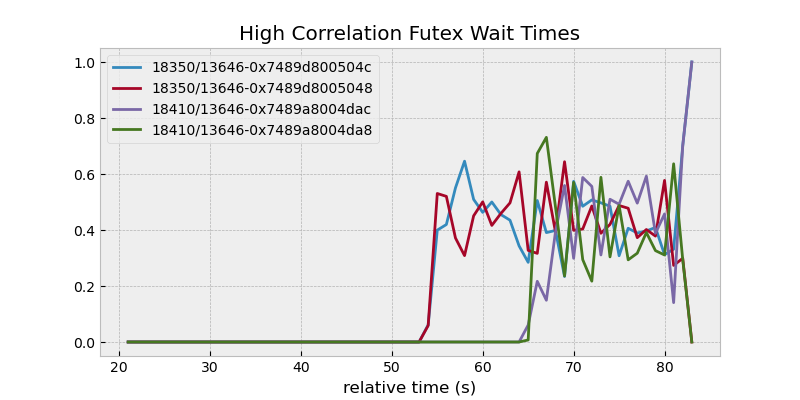

In [80]:
import re

START_TIMESTAMP = MIN_TIMESTAMP + 20
END_TIMESTAMP = MIN_TIMESTAMP + 84

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wait' in s, metric_files))

plt.close("all")
plt.figure(figsize=(8, 4))
plt.title("High Correlation Futex Wait Times")
plt.xlabel("relative time (s)")
threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
futex_threads = set()
futex_address = set()
for thread in threads[10:20]:
    files = metric_files[metric_files.str.contains(f"13646/{thread}/")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
    futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_wait_rate")].append(pd.Index(["epoch_s"]))
    metrics = metrics.loc[:, futex_wait_filter]
    metrics = pd.merge(metrics, target, on="epoch_s", how="outer")
    metrics = metrics.loc[(metrics["epoch_s"] > START_TIMESTAMP) & (metrics["epoch_s"] < END_TIMESTAMP), :]
    
    corr = metrics.corr()["delay_ms"]
    corr = corr.sort_values(ascending=False)
    corr = corr[corr.abs() > 0.5].dropna()
    
    for col in corr.index:
        if "epoch_s" in col or "delay_ms" in col: 
            continue
        futex = re.sub(r".*/wait/(.*?)/.*", r"\1", col)
        futex_threads.add(thread)
        futex_address.add(futex)
        plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}/{futex}")
plt.legend()
plt.show()

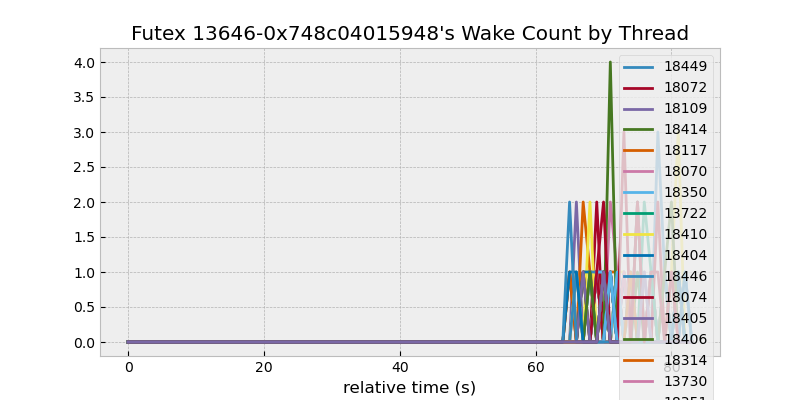

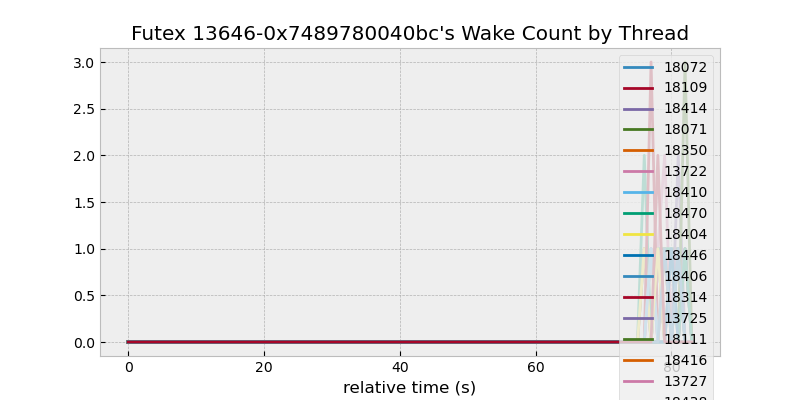

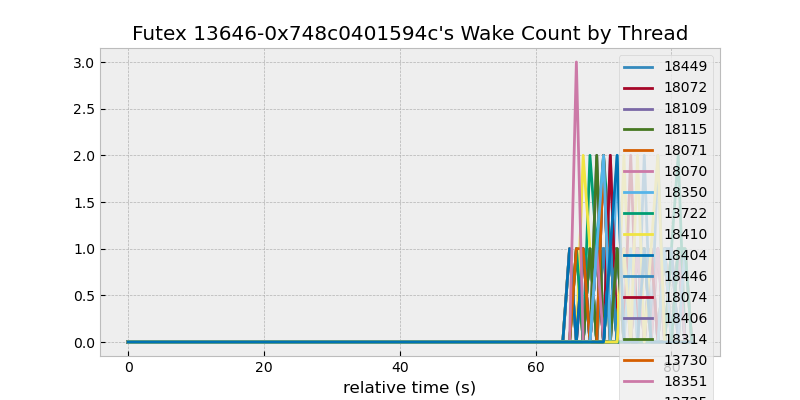

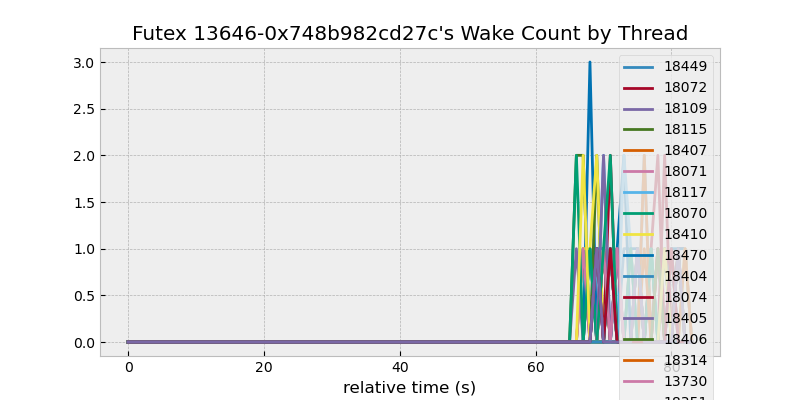

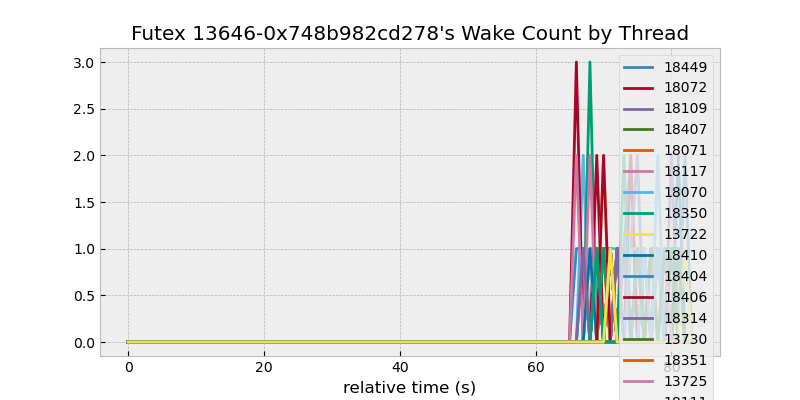

In [76]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

plt.close('all')

for futex in futex_address:
    files = metric_files[metric_files.str.contains(f"{futex}")]
    plt.figure(figsize=(8, 4))
    plt.title(f"Futex {futex}'s Wake Count by Thread")
    plt.xlabel("relative time (s)")
    threads = files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
    
    res = pd.Series(dtype="Float64")
    res.name = "value"
    for thread in threads:
        thread_files = files[files.str.contains(f"/{TARGET_PID}/{thread}/")]
        metrics = v0_2_0.metric_files_to_df(thread_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        col_filter = metrics.columns[metrics.columns.str.contains("futex_count")]
        for col in col_filter:
            sub = metrics.loc[:, ["epoch_s", col]].set_index("epoch_s")
            sub.columns = ["value"]
            res = res.add(sub["value"], fill_value=0)            
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}")
    # plt.xlim()
    # res = res.reset_index()
    # plt.plot(res["epoch_s"] - MIN_TIMESTAMP, res["value"], label="total")
    plt.legend()
    plt.show()

In [79]:
futex_address

{'13646-0x7489a8004da8',
 '13646-0x7489a8004dac',
 '13646-0x7489d8005048',
 '13646-0x7489d800504c'}

In [66]:
display(tmp_sleep_threads - futex_threads)
display(futex_threads - tmp_sleep_threads, len(futex_threads))

{'13719',
 '13720',
 '13722',
 '13724',
 '13725',
 '13726',
 '13727',
 '13728',
 '13730',
 '14002',
 '18070',
 '18072',
 '18073',
 '18074',
 '18075',
 '18108',
 '18109',
 '18110',
 '18111',
 '18114',
 '18115',
 '18118',
 '18312',
 '18314',
 '18340'}

{'13706',
 '13716',
 '18383',
 '18404',
 '18413',
 '18437',
 '18439',
 '18442',
 '18444',
 '18446',
 '18447',
 '18449'}

30

**Observation**

From this information, we can conclude that all the threads that were signaled to have interesting sleep patterns during the degradation period, were also signaled to have interesting futex wait behaviour for the same period.

NameError: name 'futex_address' is not defined

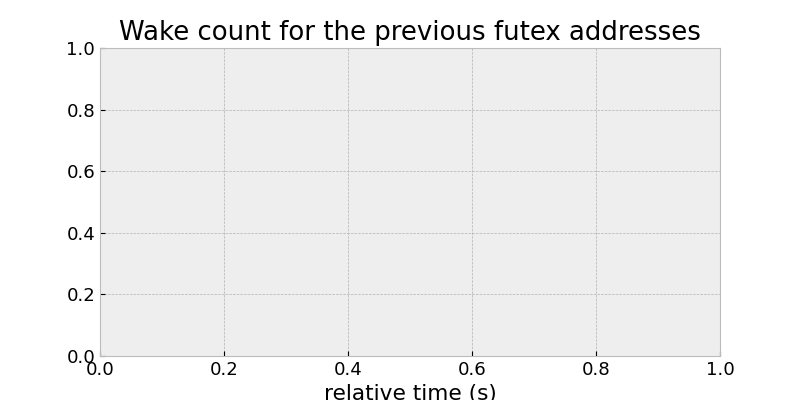

In [27]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread/{TARGET_PID}")
metric_files = pd.Series(filter(lambda s: 'futex/wake' in s, metric_files))

plt.close("all")
plt.figure(figsize=(8, 4))
plt.title("Wake count for the previous futex addresses")
plt.xlabel("relative time (s)")
threads = metric_files.str.replace(r".*/thread/\d+/(\d+)/.*", r"\1", regex=True).unique()
wake_threads = set()
for thread in threads:
    files = metric_files[metric_files.str.contains(f"{TARGET_PID}/{thread}/")]
    for futex in futex_address:
        futex_files = files[files.str.contains(f"/{futex}.csv")]
        metrics = v0_2_0.metric_files_to_df(futex_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))
        futex_wait_filter = metrics.columns[metrics.columns.str.contains("futex_count")]
        for col in futex_wait_filter:
            wake_threads.add(thread)
            plt.plot(metrics["epoch_s"] - MIN_TIMESTAMP, metrics[col], label=f"{thread}/{futex}")
plt.show()

In [26]:
print(rq_threads - wake_threads)
print(f"# wake threads: {len(wake_threads)}")

{'13719', '14002'}
# wake threads: 68


**Observation**

Having filtered out all threads that wake up the futexes that were signaled as interesting, we find that all but 2 threads that were signaled as having interesting runqueue wait time behaviour, were also threads that were responsible for waking up the threads that presented interesting futex and therefore sleeping patterns.

# IPC

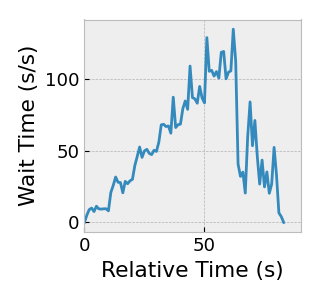

In [33]:
plt.close("all")

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/global/epoll")
metric_files = pd.Series(filter(lambda s: '172.22.0.1' in s, metric_files))
epolls = metric_files.str.replace(r".*global/epoll/(\w+)/.*", r"\1", regex=True).unique()

res = pd.Series(dtype="Float64")
for epoll in epolls:
    files = metric_files[metric_files.str.contains(f"/{epoll}/")]
    metrics = v0_2_0.metric_files_to_df(files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
    swr_filter = metrics.columns[metrics.columns.str.contains("socket_wait_rate")]
    sub = metrics.loc[:, swr_filter.append(pd.Index(["epoch_s"]))]
    long = sub.melt(id_vars=["epoch_s"], value_vars=swr_filter)
    res = res.add(long.groupby(["epoch_s"])["value"].sum(), fill_value=0)

plt.figure(figsize=FIGSIZE)
plt.ylabel("Wait Time (s/s)")
plt.xlabel("Relative Time (s)")
plt.plot(res.index - MIN_TIMESTAMP, res)
plt.xlim([0, 90])
plt.tight_layout()
plt.savefig(f"{PATH}/total_external_wait.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

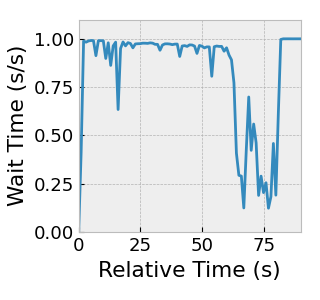

In [37]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread")
metric_files = pd.Series(filter(lambda s: 'epoll_ffff9a7a3f5e0240' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
col_filter = metrics.columns[metrics.columns.str.contains("stream_wait_rate")]
metrics = metrics.loc[:, col_filter.append(pd.Index(["epoch_s"]))]

long = metrics.melt(id_vars=["epoch_s"], value_vars=col_filter)
res = long.groupby(["epoch_s"])["value"].sum()

plt.figure(figsize=FIGSIZE)
plt.ylabel("Wait Time (s/s)")
plt.xlabel("Relative Time (s)")
plt.plot(res.index - MIN_TIMESTAMP, res)
plt.ylim([0, 1.1])
plt.xlim([0, 90])
plt.tight_layout()
plt.savefig(f"{PATH}/epoll_wait.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

**Observations**

1. The combined wait time for the host where the requests originate, increases, almost linearly until the point where the system saturates.
2. The decrease in combined wait time is not because there are less requests, it is because the threads responsible for waiting for the epoll resource is unable to wait for the resource most of the time as it is suffering cpu contention

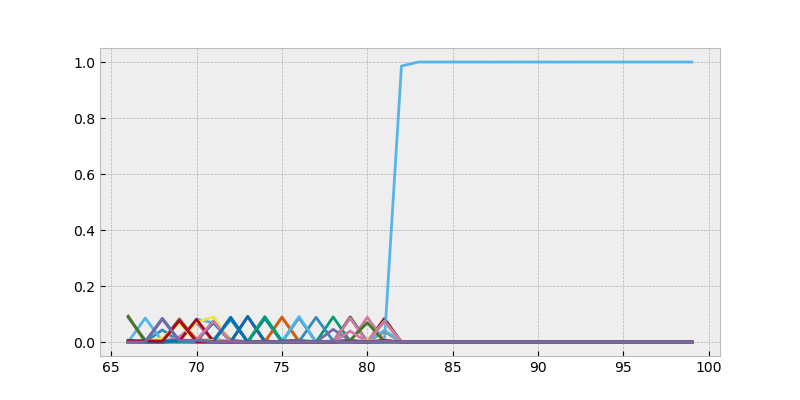

In [111]:
START_TIMESTAMP = MIN_TIMESTAMP + 65

metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread")
metric_files = pd.Series(filter(lambda s: 'epoll_ffff9a7a3f5e0240' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(MIN_TIMESTAMP, MAX_TIMESTAMP))
col_filter = metrics.columns[metrics.columns.str.contains("stream_wait_rate")]
metrics = metrics.loc[metrics["epoch_s"] > START_TIMESTAMP, col_filter.append(pd.Index(["epoch_s"]))]

threads = metrics.columns.str.replace(r"thread/\d+/(\d+?)/.*", r"\1", regex=True).unique().drop("epoch_s")
plt.figure(figsize=(8, 4))
epoll_threads = set()
for thread in threads:
    col_filter = metrics.columns[metrics.columns.str.contains(thread)]
    for col in col_filter:
        if metrics[col].max() > 0.05:
            epoll_threads.add(thread)
            plt.plot(metrics["epoch_s"]-MIN_TIMESTAMP, metrics[col], label=thread)
plt.show()
# plt.title("Time waiting for epoll ffff9a7a3f5e0240")
# plt.xlabel("relative time (s)")
# plt.plot(res.index - MIN_TIMESTAMP, res)
# plt.show()

In [116]:
len(epoll_threads-rq_threads)/len(epoll_threads)

0.0

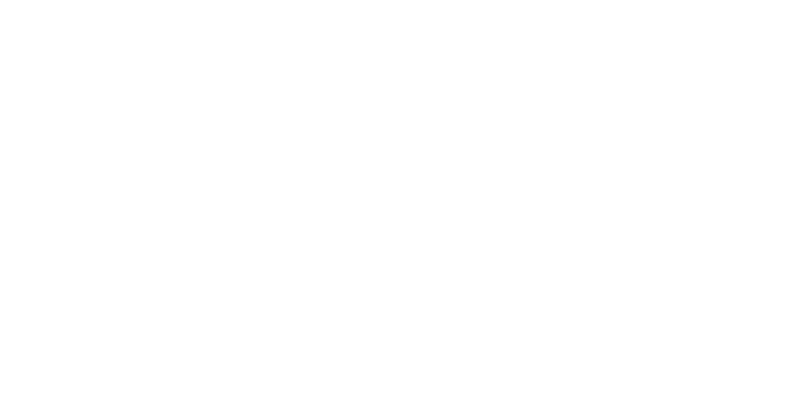

In [117]:
metric_files = v0_2_0.recursive_dfs(f"../data/{COLLECT_TS}/system-metrics/thread")
metric_files = pd.Series(filter(lambda s: 'sched/' in s, metric_files))
metrics = v0_2_0.metric_files_to_df(metric_files, epoch_interval_s=(int(MIN_TIMESTAMP), int(MAX_TIMESTAMP)))

plt.figure(figsize=(8, 4))
for thread in (epoll_threads - rq_threads):
    col_filter = metrics.columns[metrics.columns.str.contains(thread)]
    col_filter = col_filter[col_filter.str.contains("rq_time_rate")]
    for col in col_filter:
        plt.plot(metrics["epoch_s"]-MIN_TIMESTAMP, metrics[col])
plt.show()